# Plot Figure 1

This notebook plots maps of the precipitation climatology and month-to-month precipitation differences for both IMERG V06 and GPCP.

## Import Necessary Packages

In [1]:
import warnings
import calendar
import numpy as np
import xarray as xr
import proplot as pplt
from scipy.stats import t
import matplotlib.patches as patches
pplt.rc.reso='hi'
warnings.filterwarnings('ignore')

## User-Defined Configurations

Specify the directory where the raw precipitation data is, and set the directory where the figures will be saved. Define the latitude/longitude bounds for the full domain and our subregions of interest. Specify "monthly pairs" for precipitation analysis (e.g., ```MONTHPAIRS = [(6,7),(7,8)]``` instructs the analysis to examine changes from June to July and July to August).

In [2]:
FILEDIR    = '/global/cfs/cdirs/m4334/sferrett/monsoon-pod/data/raw'
SAVEDIR    = '/global/cfs/cdirs/m4334/sferrett/monsoon-pod/figs'
REGIONS    = {
    'Eastern Arabian Sea':{'latmin':9.,'latmax':19.5,'lonmin':64.,'lonmax':72.}, 
    'Central India':{'latmin':18.,'latmax':24.,'lonmin':76.,'lonmax':83.},
    'Central Bay of Bengal':{'latmin':9.,'latmax':14.5,'lonmin':86.5,'lonmax':90.},
    'Equatorial Indian Ocean':{'latmin':5.,'latmax':10.,'lonmin':62.,'lonmax':67.5},
    'Konkan Coast':{'latmin':15.,'latmax':19.5,'lonmin':69.,'lonmax':72.5}} 
LATRANGE   = (5.,25.)
LONRANGE   = (60.,90.)
MONTHPAIRS = [(6,7),(7,8)]

## Load Precipitation Datasets

Load in the IMERG V06 and GPCP precipitation data stored in ```FILEDIR```.

In [3]:
def load(filename,filedir=FILEDIR):
    filepath = f'{filedir}/{filename}'
    ds = xr.open_dataset(filepath)
    return ds.load()

In [4]:
imergpr = load('IMERG_precipitation_rate.nc')
gpcppr  = load('GPCP_precipitation_rate.nc')

## Functions for Plotting

Calculate the monthly precipitation climatology for each month in our precipitation datasets, then calculate the differences between between specified pairs of months from ```MONTHPAIRS```.

In [5]:
def calc_monthly_diffs(data,monthpairs):
    monthlypr = data.groupby('time.month').mean(dim='time')
    diffs = []
    for startmonth,endmonth in monthpairs:
        diff = monthlypr.sel(month=endmonth)-monthlypr.sel(month=startmonth)
        diffs.append(diff)
    return monthlypr,diffs

Obtain significance masks for the monthly precipitation differences via ```get_sig_masks()```. This function calculates where the month-to-month change in precipitation is statistically *in*significant
relative to interannual variability, using a two-sided *t*-test with a confidence interval specificed by ```confidencelevel``` (default is 95%).

In [6]:
def get_sig_masks(data,monthpairs,confidencelevel=0.95):
    sigmasks = []
    for startmonth,endmonth in monthpairs:
        start = data.sel(time=data['time.month']==startmonth).groupby('time.year').mean(dim='time')
        end   = data.sel(time=data['time.month']==endmonth).groupby('time.year').mean(dim='time')
        diff  = end-start
        startmean  = start.mean(dim='year')
        endmean    = end.mean(dim='year')
        meandiff   = endmean-startmean
        samplesize = len(end.year)
        degfreedom = samplesize-1
        tcrit = t.ppf(confidencelevel/2,degfreedom)
        tstat = meandiff/(diff.std(dim='year',ddof=1)/np.sqrt(samplesize))
        sigmask = (np.abs(tstat)>np.abs(tcrit))
        sigmasks.append(sigmask)
    return sigmasks

The ```create_plot()``` function generates the plot using specified plotting parameters (```plotparams```). It displays the monthly precipitation data in the top row, and precipitation differences between month pairs in the bottom row. Significance masks (displayed as hatching) and subregion boxes are also added to the bottom row. If a filename is provided, it saves the figure to the user-defined save directory (```SAVEDIR```).

In [7]:
def create_plot(monthlypr,diffs,sigmasks,monthpairs,filename=None):
    plotparams = {
        'patchstyle':dict(edgecolor='k',facecolor='none',linewidth=2),
        'prstyle':dict(cmap='ColdHot_r',cmap_kw={'left':0.5},vmin=0,vmax=18,levels=15,extend='max'),
        'maskstyle':dict(levels=[0.5,1],hatches=['//',None],colors='none'),
        'diffstyle':dict(cmap='ColdHot_r',vmin=-9,vmax=9,levels=22,extend='both'),
        'divstyle':dict(levels=[0],color='k',linewidth=0.5)}
    fig = pplt.figure(refwidth=2)
    axs = fig.subplots([[1,1,2,2,3,3],[0,4,4,5,5,0]],proj='cyl')
    axs.format(abcloc='l',abc='a)',titleloc='l',coast=True,coastlinewidth=1,
               latlim=LATRANGE,latlines=[10,15,20],lonlim=LONRANGE,lonlines=5,lonlabels=True)
    for i,month in enumerate(monthlypr.month):
        monthname = calendar.month_name[month.values]
        axs[i].format(title=f'{monthname}',latlabels=(i==0))
        m = axs[i].contourf(monthlypr.sel(month=month),**plotparams['prstyle'])
    axs[2].colorbar(m,loc='r',ticks=3,label='Precipitation (mm/day)')
    for i,(diff,sigmask,(startmonth,endmonth)) in enumerate(zip(diffs,sigmasks,monthpairs)):
        startname = calendar.month_name[startmonth]
        endname   = calendar.month_name[endmonth]
        axs[i+3].format(title=f'{endname} $-$ {startname}',latlabels=(i==0))
        m = axs[i+3].contourf(diff,**plotparams['diffstyle'])
        axs[i+3].contour(diff,**plotparams['divstyle'])
        axs[i+3].contourf(~sigmask,**plotparams['maskstyle'])
    axs[-1].colorbar(m,loc='r',ticks=3,label='$\Delta$Precipitation (mm/day)')
    for i,coords in enumerate(list(REGIONS.values())):
        axnum = 3 if i<3 else 4
        patch = patches.Rectangle(
            (coords['lonmin'],coords['latmin']),coords['lonmax']-coords['lonmin'],
             coords['latmax']-coords['latmin'],**plotparams['patchstyle'])
        axs[axnum].add_patch(patch)
    pplt.show()
    if filename:
        fig.save(f'{SAVEDIR}/{filename}',dpi=900)

## Execute Plotting

The ```plot()``` function combines all the above functions so that the workflow can be executed just by specifying the source file.

In [8]:
def plot(data,filename=None,monthpairs=MONTHPAIRS):
    monthlypr,diffs = calc_monthly_diffs(data,monthpairs)
    sigmasks = get_sig_masks(data,monthpairs,confidencelevel=0.95)
    create_plot(monthlypr,diffs,sigmasks,monthpairs)

### IMERG V06

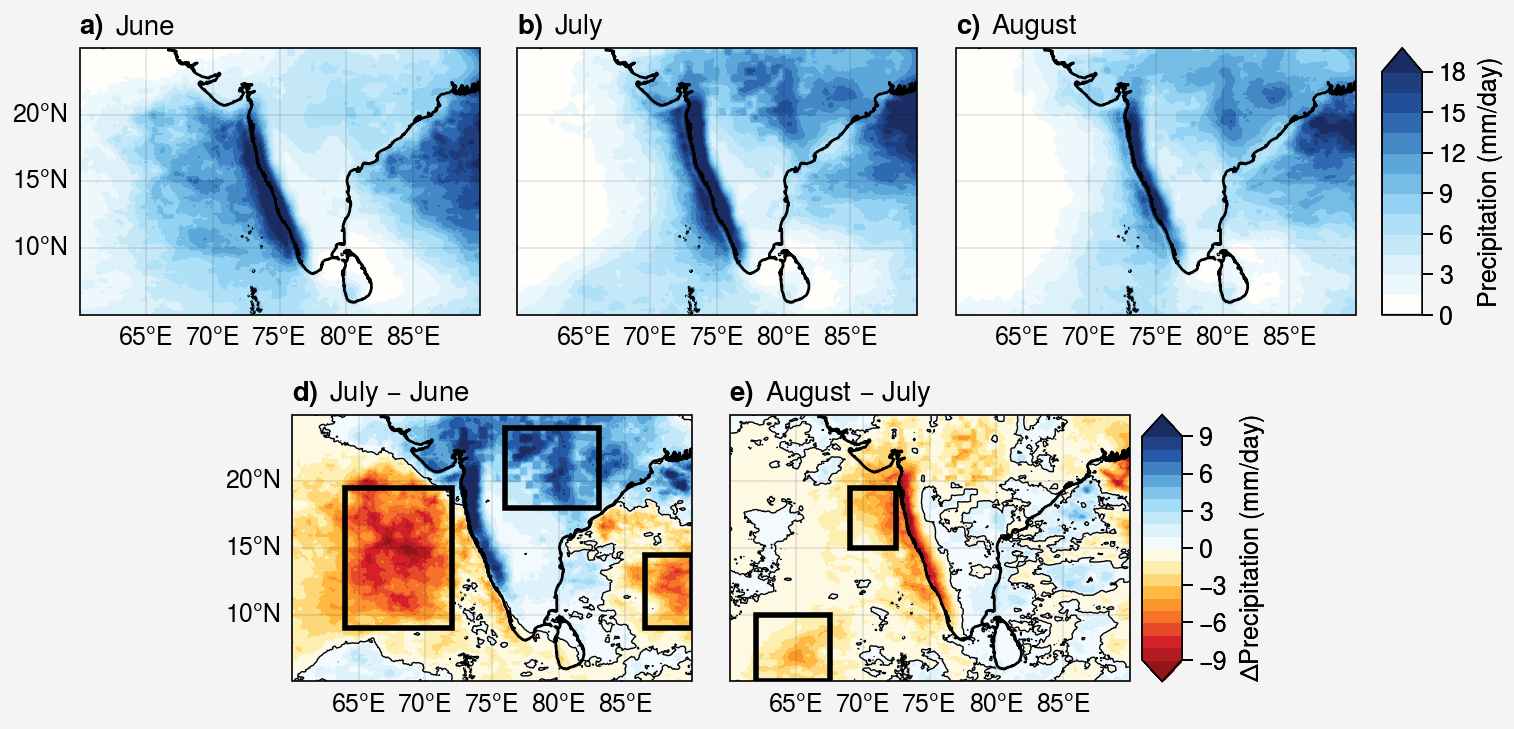

In [9]:
plot(imergpr.pr,'fig_1_IMERG.png')

### GPCP

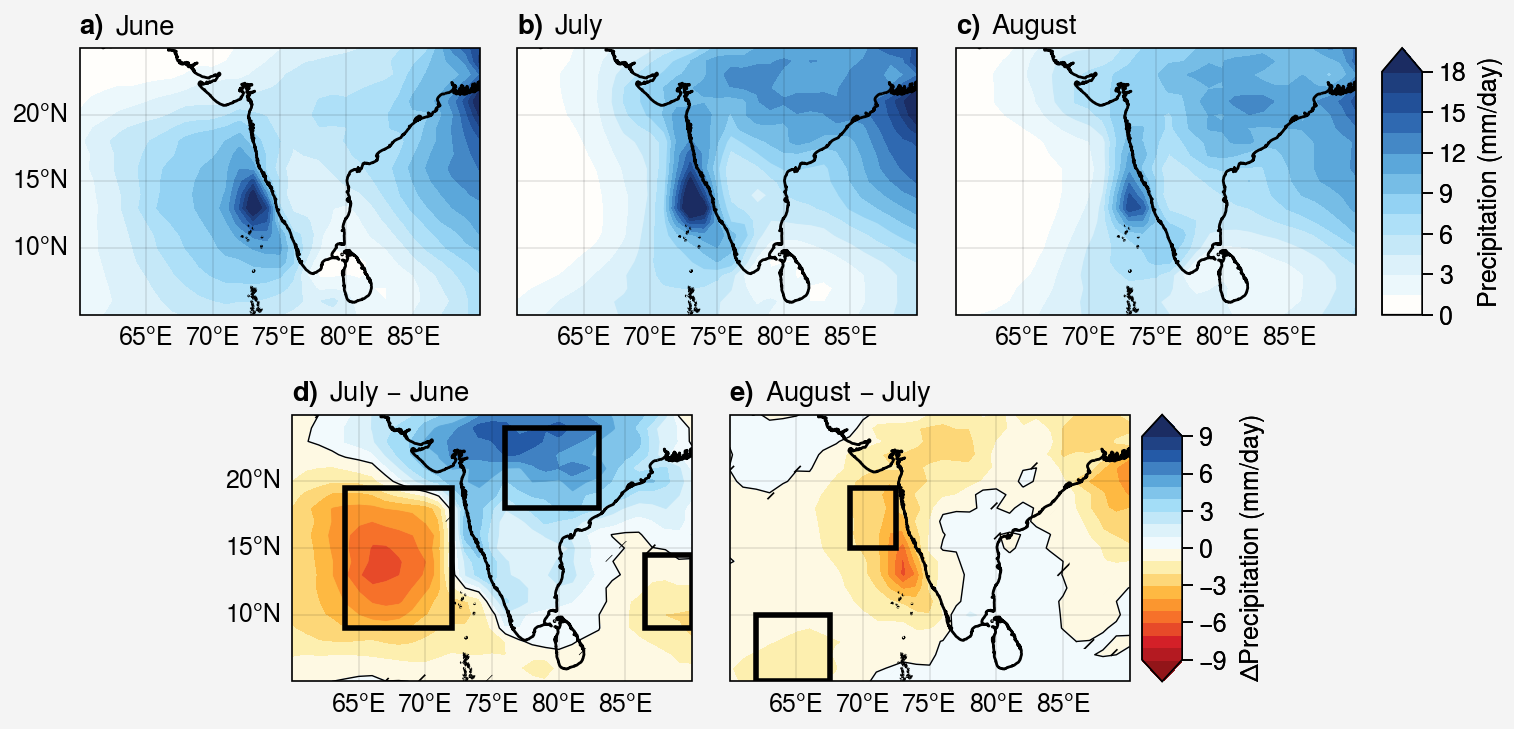

In [10]:
plot(gpcppr.pr,'fig_1_GPCP.png')